# Выбор локации для скважины

### Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**ТЗ**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.



## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# import shap

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
df_geo_0 = pd.read_csv('/datasets/geo_data_0.csv', encoding='utf-8')
df_geo_1 = pd.read_csv('/datasets/geo_data_1.csv', encoding='utf-8')
df_geo_2 = pd.read_csv('/datasets/geo_data_2.csv', encoding='utf-8')

In [3]:
df_geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
df_geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
df_geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


**Предобработка**

Посмотрим пропуски в данных, а также, статистические показатели

In [6]:
print(df_geo_0.isna().sum())
print()
print(df_geo_0.info())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [7]:
print(df_geo_1.isna().sum())
print()
print(df_geo_1.info())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [8]:
print(df_geo_2.isna().sum())
print()
print(df_geo_2.info())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


В данных нет пропусков, менять тип тоже не нужно

In [9]:
df_geo_0.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


In [10]:
df_geo_1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


In [11]:
df_geo_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


In [12]:
print(f'размер датасета 0: {df_geo_0.shape}\n'
      f'размер датасета 1: {df_geo_1.shape}\n'
      f'размер датасета 2: {df_geo_2.shape}')

размер датасета 0: (100000, 5)
размер датасета 1: (100000, 5)
размер датасета 2: (100000, 5)


**EDA**

Проведём базовый EDA для понимания, как данные вообще распределены и как они коррелируются между собой

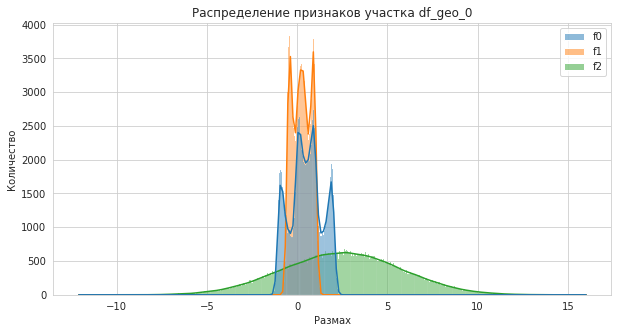

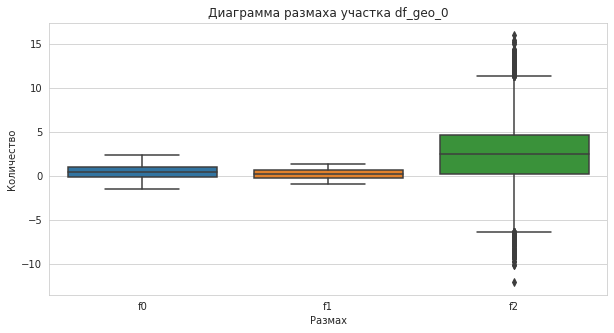

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(df_geo_0[['f0', 'f1', 'f2']], kde=True)
plt.title('Распределение признаков участка df_geo_0')
plt.xlabel('Размах')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_geo_0[['f0', 'f1', 'f2']])
plt.title('Диаграмма размаха участка df_geo_0')
plt.xlabel('Размах')
plt.ylabel('Количество')
plt.show()

**Участок 0**

Признак 1 наиболее частотный, при этом, имеет минимальный размах. Признак 2, наоборот, имеет меньшую частотность, но больший размах. Признаки 0 и 1 распределены не нормально.

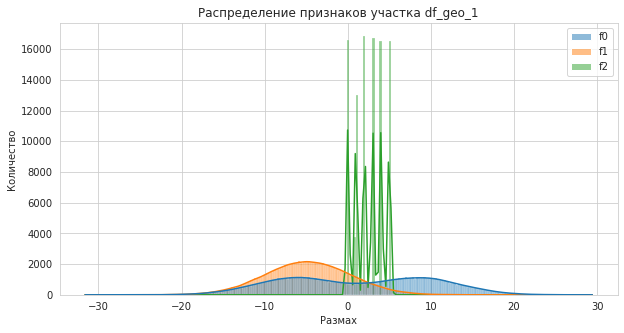

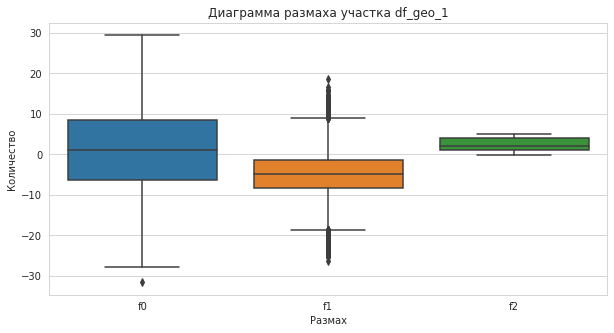

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(df_geo_1[['f0', 'f1', 'f2']], kde=True)
plt.title('Распределение признаков участка df_geo_1')
plt.xlabel('Размах')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_geo_1[['f0', 'f1', 'f2']])
plt.title('Диаграмма размаха участка df_geo_1')
plt.xlabel('Размах')
plt.ylabel('Количество')
plt.show()

**Участок 1**

Данные признака 1 распределены нормально, однако показатель его низок. У признака 2 показатель намного выше, однако на графике наблюдается сильная волатильность.

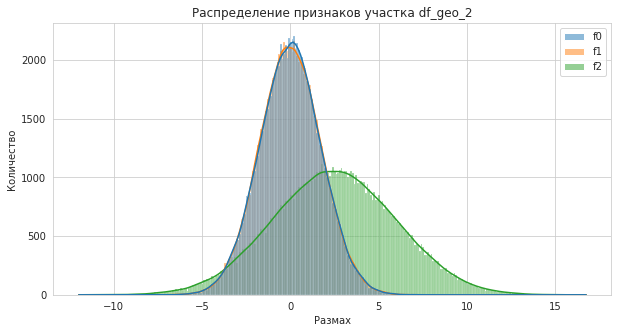

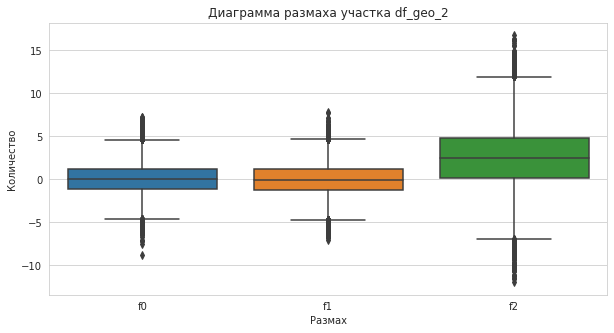

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(df_geo_2[['f0', 'f1', 'f2']], kde=True)
plt.title('Распределение признаков участка df_geo_2')
plt.xlabel('Размах')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_geo_2[['f0', 'f1', 'f2']])
plt.title('Диаграмма размаха участка df_geo_2')
plt.xlabel('Размах')
plt.ylabel('Количество')
plt.show()

**Участок 2**

Все данные распределены нормально. Признак 0 и признак 1 имеют, почти, одинаковое распределение. Среднее у них ниже, чем у признака 2, однако последний имеет больший размах

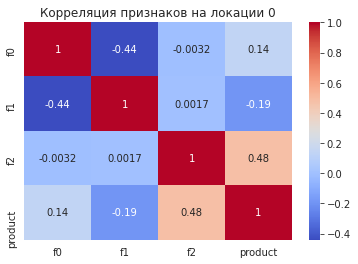

In [16]:
corr_matrix_0 = df_geo_0[['f0', 'f1', 'f2', 'product']].corr()
sns.heatmap(corr_matrix_0, cmap='coolwarm', annot=True)
plt.title('Корреляция признаков на локации 0')
plt.show()

**Участок 0**

Признаки 0 и 1 слабо коррелируются с запасами нефти. Признак 2 имеет среднюю корреляцию

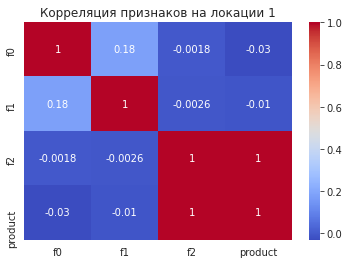

In [17]:
corr_matrix_1 = df_geo_1[['f0', 'f1', 'f2', 'product']].corr()
sns.heatmap(corr_matrix_1, cmap='coolwarm', annot=True)
plt.title('Корреляция признаков на локации 1')
plt.show()

**Участок 1**

Признаки 0 и 1 слабо коррелируются с запасами нефти. Признак 2 имеет сильную корреляцию (мультиколлиниарность)

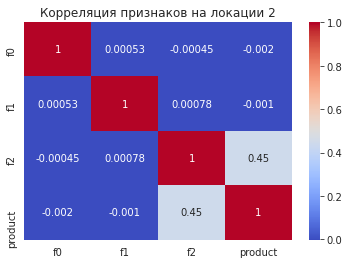

In [18]:
corr_matrix_2 = df_geo_2[['f0', 'f1', 'f2', 'product']].corr()
sns.heatmap(corr_matrix_2, cmap='coolwarm', annot=True)
plt.title('Корреляция признаков на локации 2')
plt.show()

**Участок 2**

Ситуация похожая с участком 0

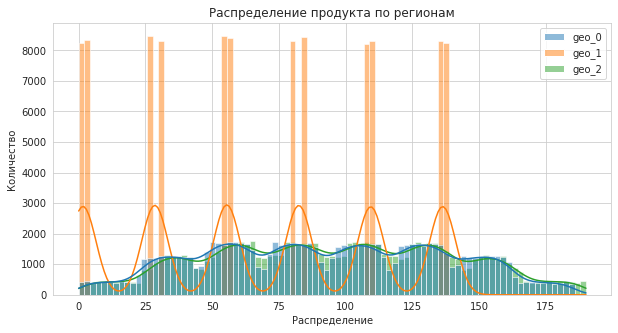

In [19]:
reg_products = pd.DataFrame({
    'geo_0': df_geo_0['product'],
    'geo_1': df_geo_1['product'],
    'geo_2': df_geo_2['product']
})

plt.figure(figsize=(10, 5))
sns.histplot(reg_products, kde=True)
plt.title('Распределение продукта по регионам')
plt.xlabel('Распределение')
plt.ylabel('Количество')
plt.show()

**Распределение запасов по локациям**

- График распределения показывает, что выводы по корреляции верны. Ситуация на участках 0 и 2 схожа (под влиянием фактора 2, они имеют аналогичное распределение)
- На локации 1 показатели запасов значительно больше, однако, имеют большую волатильность, что говорит о том, что запасаются только определённые объёмы

**Общий вывод по EDA**

- Мы проанализировали данные по добыче и запасах нефти на 3 локациях
- Локации 0 и 2 имеют аналогичные показатели запасов нефти и их корреляции и признаком 2, однако, сами признаки имеют разное распределение
- На локации 1 наблюдается мультиколлинеарность между признаком 2 и запасами, однако, несмотря на большие запасы на участке 1, есть запасы только определённых объёмов

## Обучение и проверка модели

**Модель**

В модель мы не будем "скармливать" id, так как это не категориальный и не количественный признак, а уникальный идентификатор, который не имеет смысла в данном контексте

In [20]:
def region_decorator(region_name):
    def decorator(func):
        def wrapper(*args, **kwargs):
            print(f"Модель для региона {region_name}:")
            return func(*args, **kwargs)
        
        return wrapper
    
    return decorator

In [21]:
def linear_model(df):
    features = df[['f0', 'f1', 'f2']]
    target = df['product']
    
    X_train, X_valid, y_train, y_valid = train_test_split(features, 
                                                      target, 
                                                      random_state=12345, 
                                                      test_size=0.25)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    X_valid_scaled = scaler.transform(X_valid)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    MSE = mean_squared_error(y_valid, y_pred)
    
    cv_scores = cross_val_score(model, 
                            features, 
                            target, 
                            cv=5, 
                            scoring='neg_mean_squared_error')

    cv_rmse_scores = [math.sqrt(-score) for score in cv_scores]

    mean_cv_rmse = np.mean(cv_rmse_scores)

    print(f'Среднее RMSE с использованием 5-кратной кросс-валидации: {mean_cv_rmse}')
    print(f'RMSE модели без кросс-валидации: {math.sqrt(MSE)}')
    return y_pred, y_valid

In [22]:
%%time
decorated_linear_model = region_decorator(region_name='0')(linear_model)
decorated_linear_model(df_geo_0)

Модель для региона 0:
Среднее RMSE с использованием 5-кратной кросс-валидации: 37.694272523439665
RMSE модели без кросс-валидации: 37.5794217150813
CPU times: user 148 ms, sys: 388 ms, total: 537 ms
Wall time: 507 ms


(array([ 95.89495185,  77.57258261,  77.89263965, ...,  61.50983303,
        118.18039721, 118.16939229]),
 71751     10.038645
 80493    114.551489
 2655     132.603635
 53233    169.072125
 91141    122.325180
             ...    
 12581    170.116726
 18456     93.632175
 73035    127.352259
 63834     99.782700
 43558    177.821022
 Name: product, Length: 25000, dtype: float64)

In [23]:
%%time
decorated_linear_model = region_decorator(region_name='1')(linear_model)
decorated_linear_model(df_geo_1)

Модель для региона 1:
Среднее RMSE с использованием 5-кратной кросс-валидации: 0.8904078994600948
RMSE модели без кросс-валидации: 0.893099286775617
CPU times: user 269 ms, sys: 364 ms, total: 633 ms
Wall time: 686 ms


(array([ 82.66331365,  54.43178616,  29.74875995, ..., 137.87934053,
         83.76196568,  53.95846638]),
 71751     80.859783
 80493     53.906522
 2655      30.132364
 53233     53.906522
 91141      0.000000
             ...    
 12581    137.945408
 18456    110.992147
 73035    137.945408
 63834     84.038886
 43558     53.906522
 Name: product, Length: 25000, dtype: float64)

In [24]:
%%time
decorated_linear_model = region_decorator(region_name='2')(linear_model)
decorated_linear_model(df_geo_2)

Модель для региона 2:
Среднее RMSE с использованием 5-кратной кросс-валидации: 40.05687978485549
RMSE модели без кросс-валидации: 40.02970873393434
CPU times: user 196 ms, sys: 300 ms, total: 496 ms
Wall time: 499 ms


(array([ 93.59963303,  75.10515854,  90.06680936, ...,  99.40728116,
         77.77991248, 129.03241718]),
 71751     61.212375
 80493     41.850118
 2655      57.776581
 53233    100.053761
 91141    109.897122
             ...    
 12581     28.492402
 18456     21.431303
 73035    125.487229
 63834     99.422903
 43558    127.445075
 Name: product, Length: 25000, dtype: float64)

**Вывод**

- Модели не склонны к переобучению
- Наибольшее влияние оказывает признак 2 (На SHAP графиках признаки расположены в порядке убывания влияния. Для 0 и 2 модели это признаки 2-1-0, для 1 модели это 2-0-1)
- Среднее RMSE у модели 2 равно 40 барелей, у модели 0 – 38 барелей, у молдели 1 – 0.9 барелей

## Подготовка к расчёту прибыли

In [25]:
# Сохраняем все константы

budget = 10e9  
barrels_per_well = 200  
revenue_per_barrel = 450 * 1e3 
total_points = 500  
selected_points = 200 
risk_threshold = 0.025 

Поиск точки безубыточности

In [26]:
min_volume_per_well = budget / (selected_points * revenue_per_barrel)
print(f'Минимальный объем сырья для безубыточной разработки одной скважины {min_volume_per_well} тыс. баррелей')

Минимальный объем сырья для безубыточной разработки одной скважины 111.11111111111111 тыс. баррелей


In [27]:
# Средний запас сырья в регионе

df_geo_list = [df_geo_0, df_geo_1, df_geo_2] 

for idx, df_geo in enumerate(df_geo_list):
    avg_reserve = df_geo['product'].mean()  
    print(f'Средний запас сырья в регионе {idx}: {avg_reserve:.2f} тыс. баррелей')
    
    if avg_reserve >= min_volume_per_well:
        print('Регион обладает достаточным запасом сырья для разработки')
    else:
        print('Регион не обладает достаточным запасом сырья для разработки')
    print()

Средний запас сырья в регионе 0: 92.50 тыс. баррелей
Регион не обладает достаточным запасом сырья для разработки

Средний запас сырья в регионе 1: 68.83 тыс. баррелей
Регион не обладает достаточным запасом сырья для разработки

Средний запас сырья в регионе 2: 95.00 тыс. баррелей
Регион не обладает достаточным запасом сырья для разработки



**Вывод**

- Регионы не обладают достаточными запасами сырья

## Расчёт прибыли и рисков 

In [28]:
y_pred_0, y_valid_0 = decorated_linear_model(df_geo_0)
y_pred_1, y_valid_1 = decorated_linear_model(df_geo_1)
y_pred_2, y_valid_2 = decorated_linear_model(df_geo_2)

Модель для региона 2:
Среднее RMSE с использованием 5-кратной кросс-валидации: 37.694272523439665
RMSE модели без кросс-валидации: 37.5794217150813
Модель для региона 2:
Среднее RMSE с использованием 5-кратной кросс-валидации: 0.8904078994600948
RMSE модели без кросс-валидации: 0.893099286775617
Модель для региона 2:
Среднее RMSE с использованием 5-кратной кросс-валидации: 40.05687978485549
RMSE модели без кросс-валидации: 40.02970873393434


In [29]:
budget = 10e9  
barrels_per_well = 200  
revenue_per_barrel = 450 * 1e3 
total_points = 500  
selected_points = 200 
risk_threshold = 0.025 

def profit_count(y_pred, y_valid):
    y_pred = pd.Series(y_pred)
    y_valid = pd.Series(y_valid)
    
    best_200 = y_pred.sort_values(ascending = False).head(selected_points)
    volume_200 = y_valid.iloc[best_200.index].sum()
    return volume_200 * revenue_per_barrel - budget

In [30]:
profit_0 = profit_count(y_pred_0, y_valid_0)
profit_0

3320826043.1398506

In [31]:
profit_1 = profit_count(y_pred_1, y_valid_1)
profit_1

2415086696.681511

In [32]:
profit_2 = profit_count(y_pred_2, y_valid_2)
profit_2

2710349963.5998325

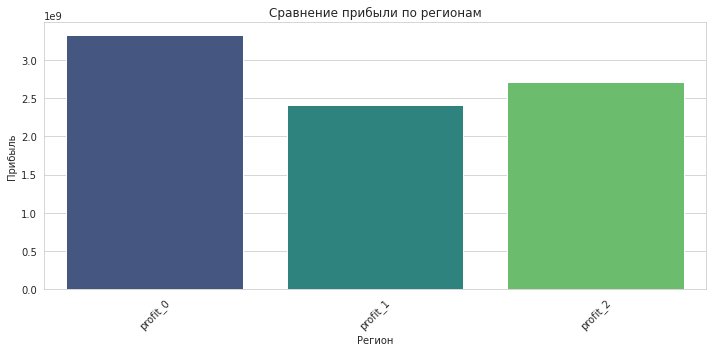

In [33]:
profit_lst = pd.DataFrame({
    'profit_0': profit_0,
    'profit_1': profit_1,
    'profit_2': profit_2
}, index=['Прибыль'])

# Транспонирование DataFrame для правильного отображения на графике
profit_lst = profit_lst.T

plt.figure(figsize=(10, 5))
sns.barplot(data=profit_lst, x=profit_lst.index, y='Прибыль', palette='viridis')
plt.title('Сравнение прибыли по регионам')
plt.ylabel('Прибыль')
plt.xlabel('Регион')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Вывод**

- Написана функция для рассчёта прибыли, с учётом моделей машинного обучения, которая делает рассчёт по топ 200 скважинам
- Наиболее прибыльный – регион 0, с прибылью ≈3.3 млрд. Далее идут регион 2 с ≈2.7 и регион 1 с ≈2.4 соответственно.

In [34]:
print(len(y_pred_0))

25000


In [35]:
print(len(y_valid_0))

25000


In [36]:
def profit_bootstrap(y_pred, y_valid):
    values = []
    y_pred = pd.Series(y_pred)
    y_valid = pd.Series(y_valid)
    state = np.random.RandomState(12345) 
    #считем прибыль для 200 лучших точек из 500 случайных 1000 раз
    for i in range(1000):
        subsample = y_pred.sample(n=500, replace=True, random_state=state)
        income =  profit_count(subsample, y_valid) 
        values.append(income) 
 
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    loss_probability = len(values[values < 0]) / len(values)
 
    print('Средняя прибыль (млн. руб): {:.2f}'.format(values.mean()/10**6))
    print('95% доверительный интервал (млн. руб):({:.2f},{:.2f})'.format(lower, upper))
    print('Вероятность убытков: {:.2%}'.format(loss_probability))

In [37]:
profit_bootstrap(y_pred_0, y_valid_0)

Средняя прибыль (млн. руб): 396.16
95% доверительный интервал (млн. руб):(-111215545.89,909766941.55)
Вероятность убытков: 6.90%


In [38]:
profit_bootstrap(y_pred_1, y_valid_1)

Средняя прибыль (млн. руб): 456.05
95% доверительный интервал (млн. руб):(33820509.40,852289453.87)
Вероятность убытков: 1.50%


In [39]:
profit_bootstrap(y_pred_2, y_valid_2)

Средняя прибыль (млн. руб): 404.40
95% доверительный интервал (млн. руб):(-163350413.40,950359574.92)
Вероятность убытков: 7.60%


**Общий вывод**

- Были проанализированы данные о нефтяных скважинах в трёх регионах
- Был проведён исследовательский анализ данных, в ходе которого рассматривалось распределение данных в по регионам, а также их корреляция. Корреляция в регионах 0 и 2 схожа
- Для каждого региона были построены модели машинного обучения. Моделью была выбрана линейная регрессия. Ключевой метрикой была выбрана RMSE. Было выявлено, что f2 – наиболее влиятельынй фактор вне зависимости от региона
- Рассчитан достаточный объём сырья для безубыточной разработки новой скважины. Сравнение полученного объём сырья со средним запасом в каждом регионе показало, что регионы пока не обладают достаточным запасом.
- По 200 лучшим точкам был рассчитан доход, доверительный интервал, риск убытков
- Посредством техники Бутстреп были рассчитаны средняя пирбыль 95-процентный доверительный интервал, а также, проанализированы риски убытков
- Самый привлекательный регион для открытия новых месторождений – это регион 1, в котором средняя прибыль 456.05 млн и наименьший риск убытков, несмотря на то, что на общем графике данные регион имеет наименьшую общую прибыль. Регионы 0 и 2 могут быть более прибыльнами, но стоит иметь в виду, что риск убытков там выше на 5-6%